# Extraction + Learning : Hardware Spec Sheets

This notebook demonstrates the full entity extraction process on transistor data sheets, extracting min storage temperatures.

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extraction

In [1]:
from snorkel.parser import HTMLParser
html_parser = HTMLParser(path='data/hardware/hardware_docs/')

In [2]:
from snorkel.parser import TableParser
table_parser = TableParser()

In [3]:
from snorkel.parser import Corpus
%time corpus = Corpus(html_parser, table_parser, max_docs=100)

Parsing documents...
Parsing contexts...
Parsed 98 documents and 630 contexts
CPU times: user 1min 5s, sys: 3.3 s, total: 1min 9s
Wall time: 1min 42s


In [4]:
from snorkel.candidates import TableNgrams
from snorkel.matchers import NumberMatcher, RangeMatcher

# Define a candidate space
table_ngrams = TableNgrams(n_max=3)

# Define a matcher
number_matcher = RangeMatcher(low=-80,high=-40)

In [9]:
from snorkel.candidates import Candidates
%time candidates = Candidates(table_ngrams, number_matcher, corpus.get_contexts())
for c in candidates.get_candidates()[:5]: print c

Extracting candidates...
CPU times: user 5.51 s, sys: 39 ms, total: 5.55 s
Wall time: 5.55 s
<TableNgram("-50", id=71-0-10-0:0-2, chars=[0,2], (row,col)=(2,2), tag=td)
<TableNgram("-50", id=97-1-22-0:0-2, chars=[0,2], (row,col)=(2,6), tag=td)
<TableNgram("-65", id=37-0-37-0:0-2, chars=[0,2], (row,col)=(10,2), tag=td)
<TableNgram("-65", id=37-0-17-0:0-2, chars=[0,2], (row,col)=(5,2), tag=td)
<TableNgram("-50", id=2-3-71-0:4-6, chars=[4,6], (row,col)=(16,0), tag=td)


### Learning

First, generate gold data.

In [14]:
# read from csv
import csv
with open('data/hardware/gold_all.csv', 'rb') as csvfile:
    gold_reader = csv.reader(csvfile)
    gold = []
    for row in gold_reader:
        (doc, part, temp, label) = row
        if label=='stg_temp_min':
            gold.append((doc,temp))
gold = set(gold)
print "%s gold annotations" % len(gold)

# match with candidates
gt_dict = {}
for c in candidates.get_candidates():
    filename = (corpus.get_doc(c.doc_id).file).split('.')[0]
    temp = c.get_attrib_span('words')
    label = 1 if (filename, temp) in gold else -1
    gt_dict[c.uid] = label
print "%s out of %s candidates are positive" % (gt_dict.values().count(1), len(gt_dict))

98 gold annotations
63 out of 163 candidates are positive


Then confirm that features work:

In [15]:
from snorkel.features import TableNgramFeaturizer
featurizer = TableNgramFeaturizer(candidates, corpus)
featurizer.get_features_by_id(candidates.get_candidates()[2].id)[:10]

Extracting features...
Extracted 1951 features for each of 163 candidates


[u'BASIC_NGRAM_-65',
 'TABLE_ROW_NUM_10',
 'TABLE_COL_NUM_2',
 'TABLE_HTML_TAG_td',
 'TABLE_HTML_ATTR_style=width:76pt;border-top-style:solid;border-top-width:1pt;border-left-style:solid;border-left-width:1pt;border-bottom-style:solid;border-bottom-width:1pt;border-right-style:solid;border-right-width:1pt',
 'TABLE_HTML_ANC_TAG_tr',
 'TABLE_HTML_ANC_TAG_table',
 'TABLE_HTML_ANC_TAG_body',
 'TABLE_HTML_ANC_ATTR_style=height:12pt',
 'TABLE_HTML_ANC_ATTR_style=border-collapse:collapse']

We now build a legacy DDLiteModel with which we will do learning.

In [16]:
from snorkel.snorkel import DDLiteModel
DDL = DDLiteModel(candidates.get_candidates(), featurizer.get_features(), gt_dict)

DDL.set_holdout(idxs=range(50), validation_frac=0.5)
print "%s training data" % len(DDL.gt.get_labeled_ground_truth('training')[0])
print "%s test data" % len(DDL.gt.get_labeled_ground_truth('test')[0])
print "%s validation data" % len(DDL.gt.get_labeled_ground_truth('validation')[0])

113 training data
25 test data
25 validation data


Define labeling functions:

In [17]:
def LF_to(m):
    return 1 if 'to' in m.post_window('words') else 0
def LF_storage(m):
    return 1 if 'storage' in m.aligned('words') else -1
def LF_tstg(m):
    return 1 if 'tstg' in m.aligned('words') else -1
def LF_temperature(m):
    return 1 if 'temperature' in m.aligned('words') else -1

In [18]:
LFs = [LF_to, LF_storage, LF_tstg, LF_temperature]
DDL.apply_lfs(LFs, clear=True)

In [19]:
print DDL.lf_names
DDL.print_lf_stats()

['LF_to', 'LF_storage', 'LF_tstg', 'LF_temperature']
LF stats on training set
Coverage:	100.000%
Overlap:	100.000%
Conflict:	15.044%


In [20]:
DDL.top_conflict_lfs(n=3)

Labeling function,Percent candidates where LF has conflict
LF_to,4.42%
LF_storage,15.04%
LF_temperature,15.04%


In [21]:
DDL.lowest_coverage_lfs(n=3)

Labeling function,Candidate coverage
LF_storage,100.00%
LF_temperature,100.00%
LF_tstg,100.00%


Now learn, baby, learn!

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.665616
	Learning epoch = 250	Gradient mag. = 0.613791
Final gradient magnitude for rate=0.01, mu=1e-07: 0.372
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.181905
	Learning epoch = 250	Gradient mag. = 0.190337
	Learning epoch = 500	Gradient mag. = 0.189210
	Learning epoch = 750	Gradient mag. = 0.188100
	Learning epoch = 1000	Gradient mag. = 0.187005
	Learning epoch = 1250	Gradient mag. = 0.185925
	Learning epoch = 1500	Gradient mag. = 0.184860
	Learning epoch = 1750	Gradient mag. = 0.183809
	Learning epoch = 2000	Gradient mag. = 0.182773
	Learning epoch = 2250	Gradient mag. = 0.181749
	Learning epoch = 2500	Gradient mag. = 0.180739
	Learning epoch = 2750	Gradient mag. = 0.179742
Final gradient magnitude for rate=0.01, mu=1e-09: 0.179
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.181905
	Learning epoch = 250	Gradient mag. = 0

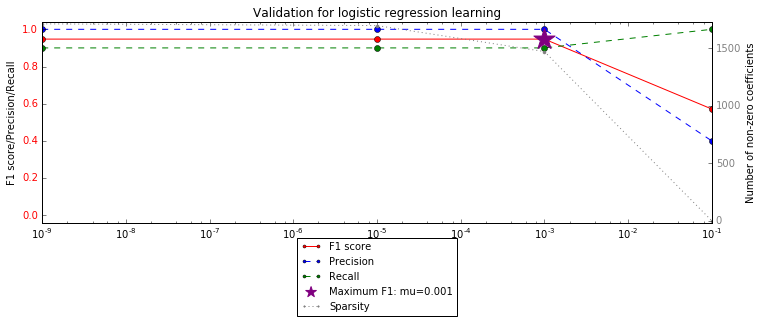

CPU times: user 3.73 s, sys: 60.8 ms, total: 3.79 s
Wall time: 3.82 s


<snorkel.snorkel.ModelLog instance at 0x113539e60>

In [22]:
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

In [23]:
DDL.show_log()
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
print "Full model accuracy: {:.3f}".format(acc_feats)

Full model accuracy: 0.980


Tune in next time for relation extraction!